# PRODIGY INFOTECH VIRTUAL INTERNSHIP - DS TASK 3
Analyzing the custom United Kingdom traffic accident data to identify patterns related road conditions, weather, time and date

In [1]:
!pip install --quiet scikit-learn folium

In [2]:
import pandas as pd

df = pd.read_csv("/content/Road Accident Data.csv", low_memory=False, nrows=100000)
print("Loaded rows:", len(df))
print("Columns:", df.columns.tolist())
df.head()

Loaded rows: 100000
Columns: ['Accident_Index', 'Accident Date', 'Month', 'Day_of_Week', 'Year', 'Junction_Control', 'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions', 'Local_Authority_(District)', 'Carriageway_Hazards', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type']


,Accident_Index,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
0,200901BS70001,1/1/2021,Jan,Thursday,2021,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,...,1,2,Metropolitan Police,Dry,One way street,30,15:11,Urban,Fine no high winds,Car
1,200901BS70002,1/5/2021,Jan,Monday,2021,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,...,11,2,Metropolitan Police,Wet or damp,Single carriageway,30,10:59,Urban,Fine no high winds,Taxi/Private hire car
2,200901BS70003,1/4/2021,Jan,Sunday,2021,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,...,1,2,Metropolitan Police,Dry,Single carriageway,30,14:19,Urban,Fine no high winds,Taxi/Private hire car
3,200901BS70004,1/5/2021,Jan,Monday,2021,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,...,1,2,Metropolitan Police,Frost or ice,Single carriageway,30,8:10,Urban,Other,Motorcycle over 500cc
4,200901BS70005,1/6/2021,Jan,Tuesday,2021,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,...,1,2,Metropolitan Police,Dry,Single carriageway,30,17:25,Urban,Fine no high winds,Car


In [4]:
import numpy as np

df["Accident Date"] = pd.to_datetime(df["Accident Date"], errors="coerce", dayfirst=True)

def parse_time(t):
    t = str(t).strip()
    if ":" in t:
        parts = t.split(":")
        if len(parts) == 2 and parts[0].isdigit() and parts[1].isdigit():
            h = int(parts[0]); m = int(parts[1])
            if 0 <= h < 24 and 0 <= m < 60:
                return f"{h:02d}:{m:02d}"
    if t.isdigit():
        if len(t) <= 2:
            h = int(t); return f"{h:02d}:00"
        elif len(t) in (3,4):
            if len(t)==3:
                h=int(t[0]); m=int(t[1:])
            else:
                h=int(t[:2]); m=int(t[2:])
            if 0 <= h < 24 and 0 <= m < 60:
                return f"{h:02d}:{m:02d}"
    return "00:00"

df["Time"] = df["Time"].fillna("0000").astype(str).apply(parse_time)
df["Datetime"] = pd.to_datetime(df["Accident Date"].dt.strftime("%Y-%m-%d") + " " + df["Time"], errors="coerce")

df["hour"] = df["Datetime"].dt.hour.fillna(0).astype(int)
df["dayofweek"] = df["Datetime"].dt.day_name().fillna("Unknown")
df["is_night"] = df["hour"].apply(lambda h: 1 if (h < 6 or h >= 18) else 0)

df["Accident_Severity_Cat"] = df["Accident_Severity"].str.strip().str.lower()
df["high_severity"] = df["Accident_Severity_Cat"].apply(lambda x: 1 if x in ["serious", "fatal"] else 0)

for col in ["Weather_Conditions", "Road_Surface_Conditions", "Light_Conditions", "Road_Type"]:
    if col in df.columns:
        df[col] = df[col].fillna("Unknown").astype(str)


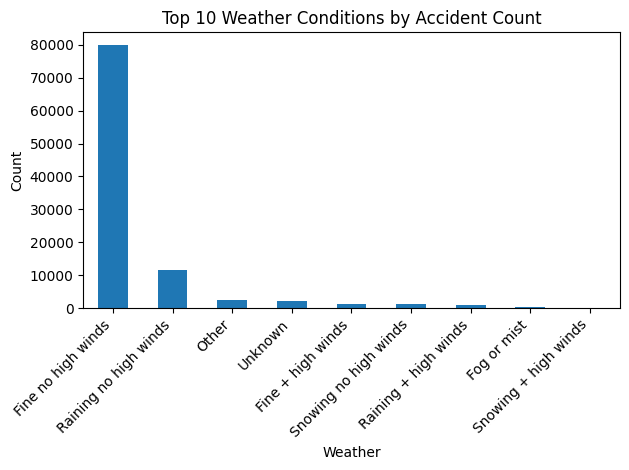

In [5]:
import matplotlib.pyplot as plt

# Accident count by weather (top 10)
weather_counts = df["Weather_Conditions"].value_counts().nlargest(10)
plt.figure()
weather_counts.plot(kind="bar")
plt.title("Top 10 Weather Conditions by Accident Count")
plt.xlabel("Weather")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

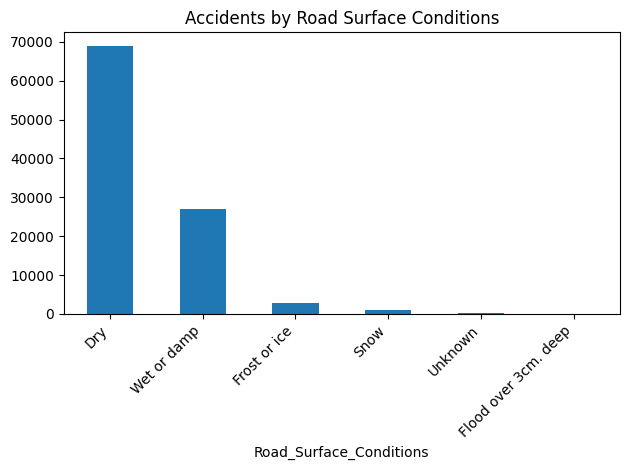

In [6]:
plt.figure()
df["Road_Surface_Conditions"].value_counts().plot(kind="bar")
plt.title("Accidents by Road Surface Conditions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

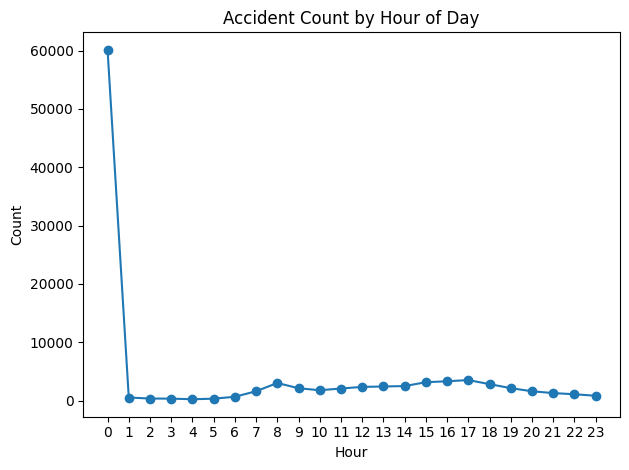

In [7]:
hourly = df.groupby("hour").size()
plt.figure()
plt.plot(hourly.index, hourly.values, marker="o")
plt.title("Accident Count by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

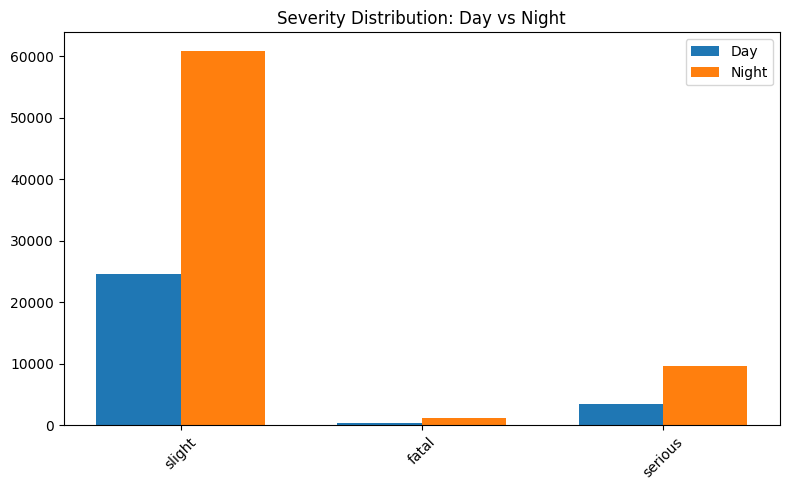

In [8]:
import numpy as np
day_df = df[df["is_night"]==0]["Accident_Severity_Cat"].value_counts()
night_df = df[df["is_night"]==1]["Accident_Severity_Cat"].value_counts()
labels = list(set(day_df.index).union(set(night_df.index)))

day_vals = [day_df.get(l,0) for l in labels]
night_vals = [night_df.get(l,0) for l in labels]

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(8,5))
plt.bar(x - width/2, day_vals, width=width, label="Day")
plt.bar(x + width/2, night_vals, width=width, label="Night")
plt.xticks(x, labels, rotation=45)
plt.title("Severity Distribution: Day vs Night")
plt.legend()
plt.tight_layout()
plt.show()

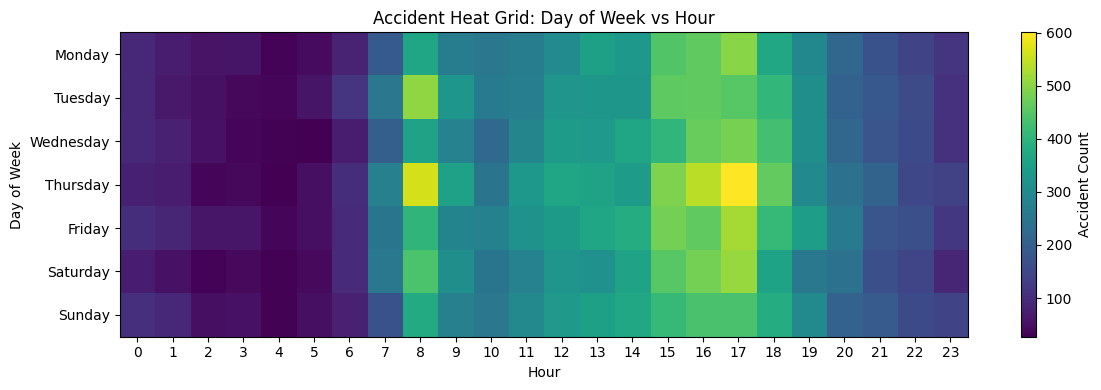

In [9]:
# Pivot table: day vs hour
pivot = df.pivot_table(index="dayofweek", columns="hour", values="Accident_Index", aggfunc="count")
ordered_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivot = pivot.reindex(ordered_days).fillna(0)

plt.figure(figsize=(12,4))
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="Accident Count")
plt.yticks(range(len(pivot.index)), pivot.index)
plt.xticks(range(0,24))
plt.xlabel("Hour")
plt.ylabel("Day of Week")
plt.title("Accident Heat Grid: Day of Week vs Hour")
plt.tight_layout()
plt.show()


In [10]:
import folium
from folium.plugins import HeatMap

valid_geo = df.dropna(subset=["Latitude", "Longitude"])
mid_lat = valid_geo["Latitude"].mean()
mid_lng = valid_geo["Longitude"].mean()

m = folium.Map(location=[mid_lat, mid_lng], zoom_start=10)
heat_data = valid_geo.apply(lambda r: [r["Latitude"], r["Longitude"], 2 if r["high_severity"]==1 else 1], axis=1).tolist()
HeatMap(heat_data, radius=8, blur=15, max_zoom=13).add_to(m)
m.save("accident_hotspot_heatmap.html")
print("Heatmap saved to accident_hotspot_heatmap.html")
from IPython.display import IFrame
IFrame("accident_hotspot_heatmap.html", width=700, height=500)


Heatmap saved to accident_hotspot_heatmap.html


Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.42      0.57     17080
           1       0.16      0.65      0.26      2920

    accuracy                           0.46     20000
   macro avg       0.52      0.54      0.42     20000
weighted avg       0.77      0.46      0.53     20000

Confusion Matrix:
 [[7258 9822]
 [1024 1896]]


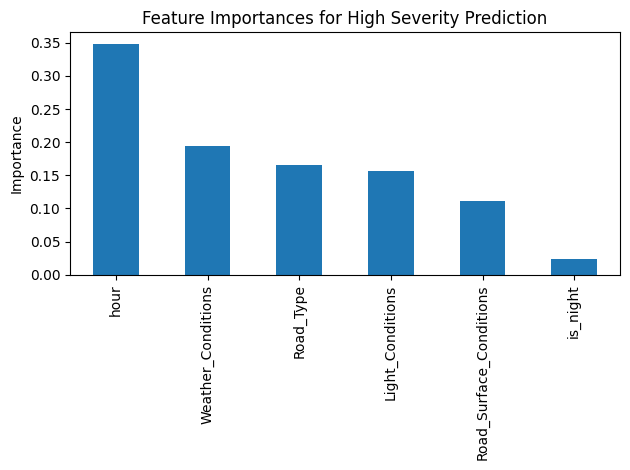

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

# Select features
feature_cols = ["hour", "is_night", "Weather_Conditions", "Road_Surface_Conditions", "Light_Conditions", "Road_Type"]
model_df = df[feature_cols + ["high_severity"]].copy()

# Encode categoricals
for col in ["Weather_Conditions", "Road_Surface_Conditions", "Light_Conditions", "Road_Type"]:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col].astype(str))

X = model_df[feature_cols]
y = model_df["high_severity"]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)

# Train
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance
importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure()
importances.plot(kind="bar")
plt.title("Feature Importances for High Severity Prediction")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
